In [17]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
import re
import numpy as np
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from kerastuner import HyperModel, RandomSearch

# Load the Dataset

In [18]:

# Load the dataset
file_path = r"E:\Class\sem3\deep learning\ass-5\IMDB Dataset.csv"
df = pd.read_csv(file_path)

In [31]:
df.head()

,review,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production the filming tech...,positive
2,i thought this was a wonderful way to spend ti...,positive
3,basically theres a family where a little boy j...,negative
4,petter matteis love in the time of money is a ...,positive


# Preprocess the Data

In [19]:
# Download stopwords
nltk.download('stopwords')

# Function to preprocess the text
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    return text

# Apply preprocessing to the review column
df['review'] = df['review'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kunch\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [20]:
# Tokenization
max_features = 10000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(df['review'])
sequences = tokenizer.texts_to_sequences(df['review'])


In [21]:

# Pad sequences
maxlen = 500
X = pad_sequences(sequences, maxlen=maxlen)

# Prepare labels
y = df['sentiment'].values  # Assuming 'sentiment' is your target column
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Train Test Split

In [22]:

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [23]:

# Train Word2Vec model on the tokenized reviews
tokenized_reviews = [review.split() for review in df['review']]
word2vec_model = Word2Vec(sentences=tokenized_reviews, vector_size=100, window=5, min_count=1, workers=4)


In [24]:
# Create embeddings for the training and test data
def create_embedding_matrix(tokenizer, word2vec_model):
    embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, word2vec_model.vector_size))
    for word, i in tokenizer.word_index.items():
        if word in word2vec_model.wv:
            embedding_matrix[i] = word2vec_model.wv[word]
    return embedding_matrix

embedding_matrix = create_embedding_matrix(tokenizer, word2vec_model)

# LSTM model

In [25]:

# Define the LSTM model
def create_model(embedding_dim=100, lstm_units=100, dropout_rate=0.2):
    model = Sequential()
    model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=embedding_dim, weights=[embedding_matrix], trainable=False))
    model.add(LSTM(units=lstm_units, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))  # For binary classification
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Hyper parameter tuning

In [26]:


# Hyperparameter tuning
class LSTMHyperModel(HyperModel):
    def build(self, hp):
        embedding_dim = 100  # Fixed embedding dimension
        lstm_units = hp.Int('lstm_units', min_value=50, max_value=200, step=50)
        dropout_rate = hp.Float('dropout_rate', 0.1, 0.5)
        
        model = create_model(embedding_dim, lstm_units, dropout_rate)
        return model

hypermodel = LSTMHyperModel()

tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='my_dir',
    project_name='lstm_hyperparam_tuning'
)

tuner.search(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]




Trial 5 Complete [02h 10m 07s]
val_accuracy: 0.9046000242233276

Best val_accuracy So Far: 0.9075999855995178
Total elapsed time: 05h 24m 21s


C:\Users\kunch\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [38]:
from tensorflow.keras.callbacks import History

# Train the best LSTM model and capture the training history
history = best_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the best LSTM model
loss, accuracy = best_model.evaluate(X_test, y_test)
print(f'LSTM Test Loss: {loss}')
print(f'LSTM Test Accuracy: {accuracy}')




Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 324s 259ms/step - accuracy: 0.9874 - loss: 0.0372 - val_accuracy: 0.8991 - val_loss: 0.4034
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 328s 262ms/step - accuracy: 0.9899 - loss: 0.0279 - val_accuracy: 0.9008 - val_loss: 0.4048
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 325s 260ms/step - accuracy: 0.9882 - loss: 0.0369 - val_accuracy: 0.8989 - val_loss: 0.4934
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 327s 262ms/step - accuracy: 0.9922 - loss: 0.0244 - val_accuracy: 0.9005 - val_loss: 0.5098
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 326s 261ms/step - accuracy: 0.9906 - loss: 0.0275 - val_accuracy: 0.8938 - val_loss: 0.5200
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 328s 262ms/step - accuracy: 0.9898 - loss: 0.0294 - val_accuracy: 0.9001 - val_loss: 0.4905
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 323s 258ms/step - accuracy: 0.9915 - loss: 0.0249 - val_accuracy: 0.9019 - val_loss: 0.5161
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 323s 259ms/step - ac

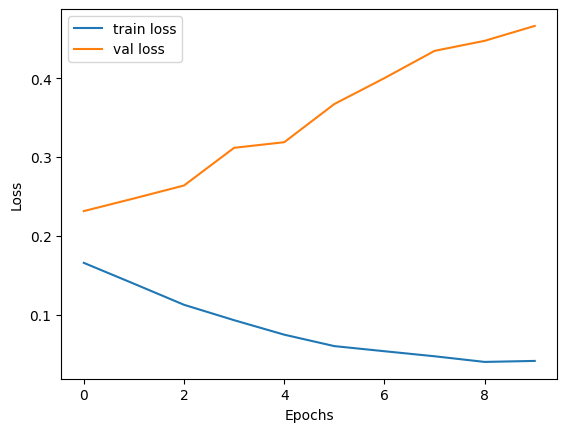

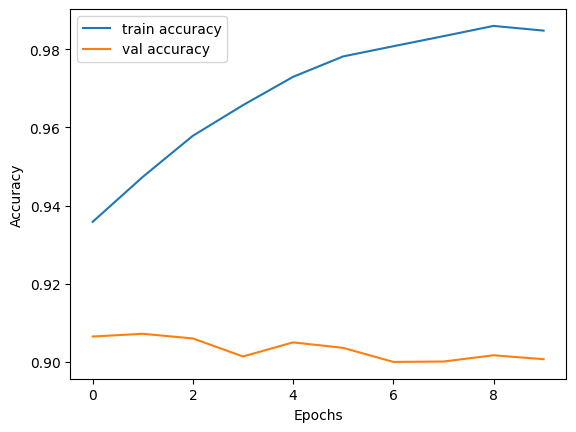

In [36]:

import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluate the model

In [27]:
# Evaluate the model
loss, accuracy = best_model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 81ms/step - accuracy: 0.9077 - loss: 0.2340
Test Accuracy: 0.9075999855995178


# simple feedforward neural 


In [28]:
from tensorflow.keras.layers import Embedding, Dense, Dropout, Flatten
def create_fnn_model():
    model = Sequential()
    model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, weights=[embedding_matrix], trainable=False, input_length=maxlen))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

fnn_model = create_fnn_model()


C:\Users\kunch\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [32]:

# Train the Feedforward Neural Network
history_fnn =fnn_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the FNN model
fnn_loss, fnn_accuracy = fnn_model.evaluate(X_test, y_test)
print(f'FNN Test Accuracy: {fnn_accuracy}')

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 42s 34ms/step - accuracy: 0.8853 - loss: 0.2226 - val_accuracy: 0.7882 - val_loss: 0.6367
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 42s 34ms/step - accuracy: 0.8873 - loss: 0.2193 - val_accuracy: 0.7898 - val_loss: 0.6130
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 39s 32ms/step - accuracy: 0.8867 - loss: 0.2154 - val_accuracy: 0.7869 - val_loss: 0.6476
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 49s 39ms/step - accuracy: 0.8968 - loss: 0.2023 - val_accuracy: 0.7875 - val_loss: 0.7578
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 44s 36ms/step - accuracy: 0.8967 - loss: 0.2015 - val_accuracy: 0.7932 - val_loss: 0.7282
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 44s 36ms/step - accuracy: 0.8994 - loss: 0.1920 - val_accuracy: 0.7904 - val_loss: 0.7105
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 40s 32ms/step - accuracy: 0.9050 - loss: 0.1899 - val_accuracy: 0.7872 - val_loss: 0.7500
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 39s 32ms/step - accuracy: 0.9047 -

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7829 - loss: 0.8521
FNN Test Loss: 0.8363602757453918
FNN Test Accuracy: 0.7876999974250793


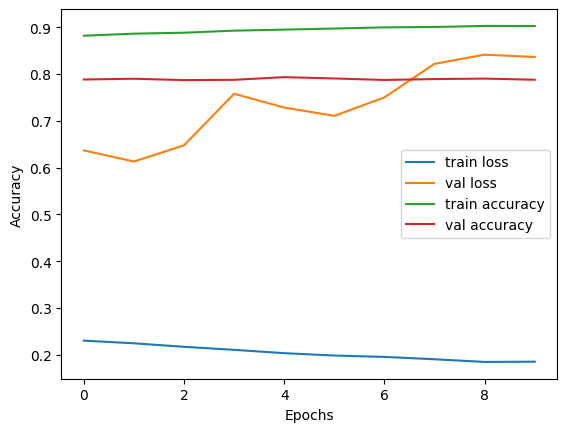

In [42]:

# Evaluate the FNN model
fnn_loss, fnn_accuracy = fnn_model.evaluate(X_test, y_test)
print(f'FNN Test Loss: {fnn_loss}')
print(f'FNN Test Accuracy: {fnn_accuracy}')

# Plot training and validation loss
plt.plot(history_fnn.history['loss'], label='train loss')
plt.plot(history_fnn.history['val_loss'], label='val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


# Plot training and validation accuracy
plt.plot(history_fnn.history['accuracy'], label='train accuracy')
plt.plot(history_fnn.history['val_accuracy'], label='val accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# Comparative Analysis

In [30]:

# Comparative Analysis
print("\nComparative Analysis:")
print(f"LSTM Test Accuracy: {accuracy}")
print(f"FNN Test Accuracy: {fnn_accuracy}")

if accuracy > fnn_accuracy:
    print("The LSTM model outperforms the Feedforward Neural Network.")
else:
    print("The Feedforward Neural Network outperforms the LSTM model.")


Comparative Analysis:
LSTM Test Accuracy: 0.9075999855995178
FNN Test Accuracy: 0.7875999808311462
The LSTM model outperforms the Feedforward Neural Network.


# Testing on an unseen data

In [46]:
import re
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Preprocess the input text
def preprocess_input_text(text):
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    return text

# Function to predict sentiment of a given text
def predict_sentiment(text, model, tokenizer, maxlen):
    # Preprocess the input text
    text = preprocess_input_text(text)
    
    # Tokenize the text
    sequence = tokenizer.texts_to_sequences([text])
    
    # Pad the sequence
    padded_sequence = pad_sequences(sequence, maxlen=maxlen)
    
    # Predict the sentiment
    prediction = model.predict(padded_sequence)
    
    # Convert the prediction to a binary output
    sentiment = "positive" if prediction >= 0.5 else "negative"
    
    return sentiment

# Manually input text
input_text = "This movie was absolutely fantastic! I loved it."

# Predict sentiment
predicted_sentiment = predict_sentiment(input_text, best_model, tokenizer, maxlen)
print(f'The predicted sentiment for the input text is: {predicted_sentiment}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
The predicted sentiment for the input text is: positive
